In [15]:
import json

# load csv file
import pandas as pd

data = pd.read_csv('data/FRANCE_COMMUNE_NIVEAU_DE_VIE-FIGARO.csv', sep=';')


In [16]:
data

,CODGEO,LIBGEO,MED14
0,01001,L'Abergement-Clémenciat,"21576,7"
1,01002,L'Abergement-de-Varey,"21672,9"
2,01004,Ambérieu-en-Bugey,"19756,1"
3,01005,Ambérieux-en-Dombes,"23204,8"
4,01006,Ambléon,"22157,5"
...,...,...,...
36616,97420,Sainte-Suzanne,"14125,6"
36617,97421,Salazie,"10827,4"
36618,97422,Le Tampon,"13349,4"
36619,97423,Les Trois-Bassins,"13104,5"


In [17]:
base_path_generated = "../../generated"
base_path_processed = "../../generated/processed"

# Load the data
restaurants_path = f"{base_path_generated}/restaurants.json"

In [18]:
# Load the restaurants data
with open(restaurants_path, 'r') as f:
    restaurants = json.load(f)

# Create a DataFrame from the restaurants data
restaurants_df = pd.DataFrame([{
    'store_id': restaurant['properties']['store_id'],
    'city': restaurant['properties']['address']['city']
} for restaurant in restaurants])

In [19]:
restaurants_df


,store_id,city
0,100,COLOMBES
1,1000,CUGNAUX
2,1001,PARIS
3,1002,BELLEY
4,1003,LAGORD
...,...,...
1535,978,AIX LES BAINS
1536,979,FRENEUSE
1537,98,SAINT BRICE SOUS FORET
1538,980,AIMARGUES


In [20]:
import unicodedata


# Function to remove accents and convert to lowercase
def normalize_text(text):
    normalized = ''.join(c for c in unicodedata.normalize('NFD', text.lower()) if unicodedata.category(c) != 'Mn')
    return normalized.replace(' ', '').replace('-', '')


In [21]:
restaurants_df['city_normalized'] = restaurants_df['city'].apply(normalize_text)
data['LIBGEO_normalized'] = data['LIBGEO'].apply(normalize_text)


In [22]:
# Merge the DataFrames with the indicator parameter set to True
merged_df = restaurants_df.merge(data, left_on='city_normalized', right_on='LIBGEO_normalized')
merged_df.drop(columns=['LIBGEO_normalized', 'city_normalized'], inplace=True)

In [23]:
merged_df.head()


,store_id,city,CODGEO,LIBGEO,MED14
0,100,COLOMBES,92025,Colombes,"20851,3"
1,605,COLOMBES,92025,Colombes,"20851,3"
2,1000,CUGNAUX,31157,Cugnaux,"22479,3"
3,1001,PARIS,75056,Paris,"26194,7"
4,102,PARIS,75056,Paris,"26194,7"


In [24]:
store_id_to_bigmac_price = pd.read_csv(f"{base_path_processed}/big_mac_prices.csv")
store_id_to_bigmac_price.head()


,store_id,big_mac_price
0,100,6.0
1,1000,5.5
2,1001,5.4
3,1002,5.6
4,1003,5.9


In [31]:
# Merge the DataFrames on the store_id column. The types are different, so we need to convert the store_id column to a string
merged_df['store_id'] = merged_df['store_id'].astype(str)
store_id_to_bigmac_price['store_id'] = store_id_to_bigmac_price['store_id'].astype(str)

bigmac_price_med14 = merged_df.merge(store_id_to_bigmac_price, on='store_id', how='left')

# Drop the rows with missing values
bigmac_price_med14.dropna(inplace=True)

bigmac_price_med14


,store_id,city,CODGEO,LIBGEO,MED14,big_mac_price
0,100,COLOMBES,92025,Colombes,"20851,3",6.00
1,605,COLOMBES,92025,Colombes,"20851,3",5.90
2,1000,CUGNAUX,31157,Cugnaux,"22479,3",5.50
3,1001,PARIS,75056,Paris,"26194,7",5.40
4,102,PARIS,75056,Paris,"26194,7",5.40
...,...,...,...,...,...,...
1681,979,FRENEUSE,76282,Freneuse,"26060,0",5.50
1682,979,FRENEUSE,78255,Freneuse,"21055,6",5.50
1683,98,SAINT BRICE SOUS FORET,95539,Saint-Brice-sous-Forêt,"22389,5",5.30
1684,980,AIMARGUES,30006,Aimargues,"19157,9",6.20


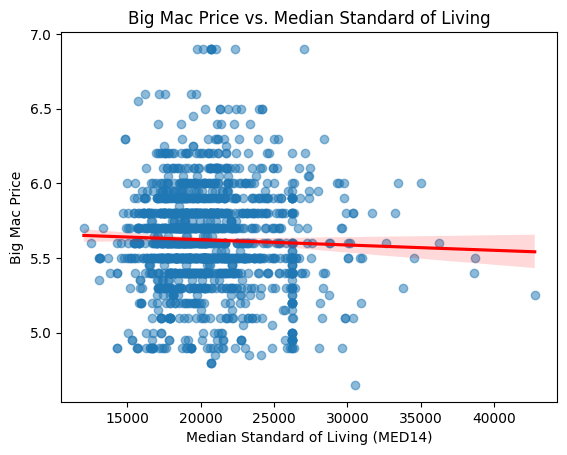

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convert the MED14 column values to float
bigmac_price_med14['MED14'] = bigmac_price_med14['MED14'].str.replace(',', '.').astype(float)

# Create a scatterplot with a regression line using seaborn
sns.regplot(data=bigmac_price_med14, x='MED14', y='big_mac_price', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# Customize the plot
plt.title('Big Mac Price vs. Median Standard of Living')
plt.xlabel('Median Standard of Living (MED14)')
plt.ylabel('Big Mac Price')

# Show the plot
plt.show()


In [33]:
# Calculate the correlation coefficient
correlation_coefficient = bigmac_price_med14['big_mac_price'].corr(bigmac_price_med14['MED14'])

print("Correlation coefficient between Big Mac price and MED14:", correlation_coefficient)


# save to json only the cols MED14 and big_mac_price
bigmac_price_med14 = bigmac_price_med14[['MED14', 'big_mac_price']]
bigmac_price_med14.to_json(f"{base_path_processed}/bigmac_price_med14.json", orient='records')


Correlation coefficient between Big Mac price and MED14: -0.036336265351289206
